# 회귀 분석

## 이진 고객 이탈

고객의 웹사이트 광고를 제공하는 마케팅 대행사에서 당사의 고객이탈율이 꽤 높다는 사실을 알게됐습니다.<br>
그 회사에서는 즉시 고객 관리자들을 할당했지만, 어떤 고객이 이탈 할 것인지 예측하는 기계학습 모델을 만들어서 가장 이탈확률이 높은 고객에게 우선적으로 고객 관리자를 배치할 수 있기를 원합니다.<br>
고객이 잠재적 이탈 고객인지 여부를 분류하는 분류모델을 만드세요.

데이터는 customer_churn.csv로 저장돼있습니다. 아래는 각 컬럼의 정의입니다.
- Name : 회사의 최근 담당자의 이름
- Age : 고객의 나이
- Total_Purchase : 구매한 총 광고
- Account_Manager : 바이너리 0 = 고객 관리자 없음, 1 = 고객 관리자 할당됨
- Years : 거래 유지 연도수
- Num_sites : 서비스를 이용 중인 웹사이트 수
- Onboard_date : 마지막 연락처가 등록된 날짜
- Location : 고객 사무실 주소
- Company : 고객 회사의 이름

모델 생성 후에는 고객이 제공하는 new_customers.csv 파일에 저장된 새로운 데이터에 대한 예측값을 제시하세요. <br>
고객은 이 데이터를 통해 관리가 필요한 고객들을 알고 싶어 합니다. <br>
cross_validate -> AUC점수


In [530]:
import pandas as pd
import numpy as np
import myfx as m
from sklearn.model_selection import (
    GridSearchCV,
    train_test_split,
    cross_validate,
    cross_val_score,
)
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc, roc_curve, roc_auc_score, RocCurveDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn import svm
import matplotlib.pyplot as plt
import seaborn as sns

### 데이터 불러오기

In [531]:
df = pd.read_csv("./data/customer_churn.csv")
new = pd.read_csv("./data/new_customers.csv", index_col=False)

In [532]:
new

,Names,Age,Total_Purchase,Account_Manager,Years,Num_Sites,Onboard_date,Location,Company
0,Andrew Mccall,37.0,9935.53,1,7.71,8.0,2011-08-29 18:37:54,"38612 Johnny Stravenue Nataliebury, WI 15717-8316",King Ltd
1,Michele Wright,23.0,7526.94,1,9.28,15.0,2013-07-22 18:19:54,"21083 Nicole Junction Suite 332, Youngport, ME...",Cannon-Benson
2,Jeremy Chang,65.0,100.00,1,1.00,15.0,2006-12-11 07:48:13,"085 Austin Views Lake Julialand, WY 63726-4298",Barron-Robertson
3,Megan Ferguson,32.0,6487.50,0,9.40,14.0,2016-10-28 05:32:13,"922 Wright Branch North Cynthialand, NC 64721",Sexton-Golden
4,Taylor Young,32.0,13147.71,1,10.00,8.0,2012-03-20 00:36:46,Unit 0789 Box 0734 DPO AP 39702,Wood LLC
5,Jessica Drake,22.0,8445.26,1,3.46,14.0,2011-02-04 19:29:27,1148 Tina Stravenue Apt. 978 South Carlos TX 2...,Parks-Robbins


### 데이터 확인

In [533]:
df.head()

,Names,Age,Total_Purchase,Account_Manager,Years,Num_Sites,Onboard_date,Location,Company,Churn
0,Cameron Williams,42.0,11066.80,0,7.22,8.0,2013-08-30 07:00:40,"10265 Elizabeth Mission Barkerburgh, AK 89518",Harvey LLC,1
1,Kevin Mueller,41.0,11916.22,0,6.50,11.0,2013-08-13 00:38:46,"6157 Frank Gardens Suite 019 Carloshaven, RI 1...",Wilson PLC,1
2,Eric Lozano,38.0,12884.75,0,6.67,12.0,2016-06-29 06:20:07,"1331 Keith Court Alyssahaven, DE 90114","Miller, Johnson and Wallace",1
3,Phillip White,42.0,8010.76,0,6.71,10.0,2014-04-22 12:43:12,"13120 Daniel Mount Angelabury, WY 30645-4695",Smith Inc,1
4,Cynthia Norton,37.0,9191.58,0,5.56,9.0,2016-01-19 15:31:15,"765 Tricia Row Karenshire, MH 71730",Love-Jones,1


In [534]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Names            900 non-null    object 
 1   Age              900 non-null    float64
 2   Total_Purchase   900 non-null    float64
 3   Account_Manager  900 non-null    int64  
 4   Years            900 non-null    float64
 5   Num_Sites        900 non-null    float64
 6   Onboard_date     900 non-null    object 
 7   Location         900 non-null    object 
 8   Company          900 non-null    object 
 9   Churn            900 non-null    int64  
dtypes: float64(4), int64(2), object(4)
memory usage: 70.4+ KB


In [535]:
df.describe()

,Age,Total_Purchase,Account_Manager,Years,Num_Sites,Churn
count,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000
mean,41.816667,10062.824033,0.481111,5.273156,8.587778,0.166667
std,6.127560,2408.644532,0.499921,1.274449,1.764836,0.372885
min,22.000000,100.000000,0.000000,1.000000,3.000000,0.000000
25%,38.000000,8497.122500,0.000000,4.450000,7.000000,0.000000
50%,42.000000,10045.870000,0.000000,5.215000,8.000000,0.000000
75%,46.000000,11760.105000,1.000000,6.110000,10.000000,0.000000
max,65.000000,18026.010000,1.000000,9.150000,14.000000,1.000000


In [536]:
df[["Names", "Location"]].value_counts()

Names               Location                                               
Aaron King          38346 Smith Prairie Arnoldside, MD 33861-4885              1
Lisa Harmon         2190 Fox Mountains North Jennifer, WV 75027-6097           1
Mary Davis          5304 Richards Run Apt. 960 Lake Emilyville, VA 21428       1
Mary Frank          11007 Tara Plains Apt. 842 South Amy, AK 31218             1
Mary Griffin        91062 Michelle Underpass Lloydmouth, ND 88737              1
                                                                              ..
Francisco Martinez  842 Hebert Wells Suite 823 North Tina, WI 75284-1996       1
Francisco Moore     7433 Matthew Stream South Susan, NE 04017-0029             1
Frank Chase         USNS Potts FPO AA 56275                                    1
Frank Coleman       686 Bonnie Locks Suite 704 Hayesburgh, SD 23695-5265       1
Zachary Walsh       25271 Roy Expressway Suite 147 Brownport, FM 59852-6150    1
Name: count, Length: 900, dtype: 

In [537]:
# 필요없는 컬럼 제거
df = df.drop(["Names", "Location", "Company"], axis=1)
new = new.drop(["Names", "Location", "Company"], axis=1)

In [538]:
df.head()

,Age,Total_Purchase,Account_Manager,Years,Num_Sites,Onboard_date,Churn
0,42.0,11066.80,0,7.22,8.0,2013-08-30 07:00:40,1
1,41.0,11916.22,0,6.50,11.0,2013-08-13 00:38:46,1
2,38.0,12884.75,0,6.67,12.0,2016-06-29 06:20:07,1
3,42.0,8010.76,0,6.71,10.0,2014-04-22 12:43:12,1
4,37.0,9191.58,0,5.56,9.0,2016-01-19 15:31:15,1


In [539]:
# sns.pairplot(df.drop("Churn", axis=1), kind="reg", height=2)

In [540]:
# df_corr = df.corr()
# sns.heatmap(
#     df_corr,
#     cbar=True,
#     annot=True,
#     square=True,
#     fmt=".2f",
#     annot_kws={"size": 10},
#     yticklabels=df_corr,
#     xticklabels=df_corr,
# )

In [541]:
df.columns

Index(['Age', 'Total_Purchase', 'Account_Manager', 'Years', 'Num_Sites',
       'Onboard_date', 'Churn'],
      dtype='object')

### 머신러닝용 데이터 전처리

우리는 수치형 데이터만 이용할 예정입니다. Account_Manager는 다루기 어렵지 않기 때문에 모델학습에 포함할 수도 있겠지만 무작위로 할당된 것이기 때문에 큰 의미가 없을 수 있습니다.

In [542]:
# Onboard_date 의 타입을 object -> datetime -> int로 변환
df["Onboard_date"] = pd.to_datetime(df["Onboard_date"])
df["Onboard_date"] = df["Onboard_date"].astype("int64")

In [543]:
new["Onboard_date"] = pd.to_datetime(new["Onboard_date"])
new["Onboard_date"] = new["Onboard_date"].astype("int64")

In [544]:
# df.drop(["Age", "Total_Purchase", "Account_Manager"], axis=1, inplace=True)
# new.drop(["Age", "Total_Purchase", "Account_Manager"], axis=1, inplace=True)

- Company 열은 비교 데이터간 있을수도 없을수도 있기에 제거하는것이 좋음.

In [545]:
# 독립변수, 종속변수 분리
x, y = m.dataset_split(df, "Churn")

In [546]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.25, random_state=3056
)

In [547]:
ss = StandardScaler()
scaled_train = ss.fit_transform(x_train)
scaled_test = ss.transform(x_test)
scaled_x = ss.transform(x)

In [548]:
scaled_new = ss.transform(new)

In [549]:
rf = KNeighborsRegressor()

In [550]:
x_train

,Age,Total_Purchase,Account_Manager,Years,Num_Sites,Onboard_date
508,43.0,10938.11,0,3.21,8.0,1138245334000000000
5,48.0,10356.02,0,5.12,8.0,1236122017000000000
590,51.0,7810.06,0,5.99,9.0,1344542033000000000
604,42.0,13081.64,0,4.66,9.0,1336827805000000000
527,32.0,12403.60,0,4.99,7.0,1212118534000000000
...,...,...,...,...,...,...
786,37.0,8316.89,0,3.60,8.0,1410948320000000000
440,39.0,10643.67,0,5.54,10.0,1431786040000000000
792,44.0,10157.21,0,6.14,7.0,1147281788000000000
870,51.0,7985.76,1,3.48,8.0,1154101661000000000


## 스케일링 미적용

In [551]:
scores = cross_validate(rf, x_train, y_train, return_train_score=True, n_jobs=-1)
scores

{'fit_time': array([0.00199914, 0.00199914, 0.00297284, 0.00300074, 0.00300121]),
 'score_time': array([0.00300074, 0.00300074, 0.00200033, 0.00200582, 0.0019989 ]),
 'test_score': array([-0.19661256, -0.20678261, -0.17849365, -0.09570909, -0.12779503]),
 'train_score': array([0.22831697, 0.18839576, 0.19935121, 0.19738536, 0.18666667])}

In [552]:
print(np.mean(scores["train_score"]), np.mean(scores["test_score"]))

0.2000231911237645 -0.16107858806474112


In [553]:
rf.fit(x_train, y_train)

KNeighborsRegressor()

In [554]:
rf = LogisticRegression(random_state=3056)
rf.fit(x_train, y_train)
# rf.oob_score_

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=3056)

In [555]:
# rf.fit(x, y)

In [556]:
rf.score(x_test, y_test)

0.8355555555555556

In [557]:
rf.predict(new)

array([0, 0, 0, 0, 0, 0], dtype=int64)

## 스케일링 적용

In [558]:
scores = cross_validate(
    rf, scaled_train, y_train, return_train_score=True, n_jobs=-1, return_estimator=True
)

In [559]:
print(np.mean(scores["train_score"]), np.mean(scores["test_score"]))

0.8881481481481481 0.8888888888888887


In [560]:
rf.fit(scaled_train, y_train)

LogisticRegression(random_state=3056)

In [589]:
rf = LogisticRegression(random_state=3056)
rf.fit(scaled_train, y_train)

LogisticRegression(random_state=3056)

In [564]:
# rf.fit(x, y)

In [590]:
rf.score(scaled_test, y_test)

0.9111111111111111

In [591]:
rf.fit(x, y)

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=3056)

In [592]:
crossval_scores = cross_val_score(rf, scaled_test, y_test, scoring="roc_auc", cv=6)
np.mean(crossval_scores)

0.9087821620583719

In [593]:
rf.predict(new)

array([0, 0, 0, 0, 0, 0], dtype=int64)

- 스케일링전 평가 0.9022
- 스케일링후 평가 0.9111

In [ ]:
score = rf.predict_proba(scaled_x)[:, 1]
score

array([6.90844313e-02, 6.21077083e-01, 8.32230397e-01, 3.43550505e-01,
       6.23762334e-02, 3.22308830e-02, 5.97079393e-01, 1.55142744e-01,
       6.44048242e-01, 7.59868003e-01, 1.92881570e-02, 7.58647640e-01,
       5.48279291e-01, 9.13435805e-01, 3.90219583e-01, 8.87640362e-01,
       8.28416512e-01, 9.35307604e-01, 8.48121178e-02, 5.42700485e-02,
       5.10318321e-01, 8.06071908e-01, 6.74479818e-01, 8.28068392e-01,
       4.28807121e-01, 4.68301044e-01, 2.81711907e-01, 7.36406172e-01,
       4.96625374e-01, 2.62075194e-01, 7.07022989e-02, 2.57439473e-01,
       2.85897094e-01, 8.42863649e-01, 6.30566779e-01, 4.82269941e-01,
       7.59624861e-01, 9.23273531e-01, 7.20705893e-01, 6.43458112e-01,
       8.75536352e-01, 1.90161962e-01, 6.83343103e-01, 7.75136224e-01,
       2.04365912e-01, 7.76079620e-01, 6.68457202e-01, 8.17844103e-01,
       7.86321136e-02, 3.08877229e-01, 2.42437660e-01, 6.17230601e-01,
       3.67989440e-01, 2.55956219e-01, 7.92361892e-01, 5.23494176e-01,
      

In [ ]:
fpr, tpr, cut = roc_curve(y, score)

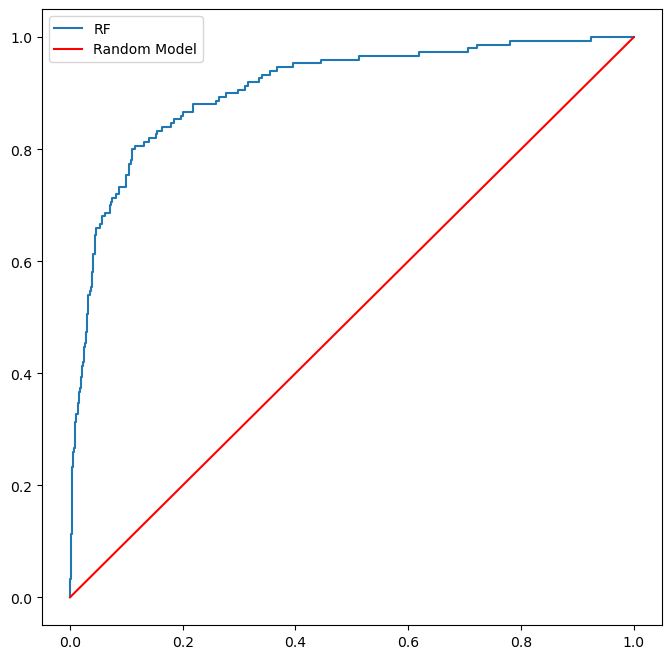

In [ ]:
fig = plt.figure(figsize=(8, 8))
fig.set_facecolor("white")
ax = fig.add_subplot()
ax.plot(fpr, tpr, label="RF")

ax.plot([0, 1], [0, 1], color="red", label="Random Model")
ax.legend()
plt.show()

In [ ]:
rf.predict(scaled_new)
rf.score(scaled_x, y)

0.8944444444444445

In [ ]:
crossval_scores = cross_val_score(rf, x, y, scoring="roc_auc", cv=10)

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

In [ ]:
np.mean(crossval_scores)

0.5

In [ ]:
params = {
    "n_estimators": [10, 100],
    "max_depth": [6, 8, 10, 12],
    "min_samples_leaf": [8, 12, 18],
    "min_samples_split": [8, 16, 20],
}

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행

grid_cv = GridSearchCV(rf, param_grid=params, cv=3, n_jobs=-1)
grid_cv.fit(scaled_x, y)

print("최적 하이퍼 파라미터: ", grid_cv.best_params_)
print("최고 예측 정확도: {:.4f}".format(grid_cv.best_score_))

ValueError: Invalid parameter 'max_depth' for estimator LogisticRegression(random_state=3056). Valid parameters are: ['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'].

In [ ]:
grid_cv.predict(scaled_new)

array([0, 1, 0, 1, 0, 0], dtype=int64)